# Clasificador de cáncer de pulmón

El objetivo de esta tarea será entrenar una red neuronal convolucional (CNN) que sea capaz de clasificar el tipo de cancer que posee un pulmón en base a las imágenes de hispatológicas obtenidas de un [conjunto de datos](https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images?resource=download) de Kaggle.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
BASE_PATH = os.path.join(".", "archive", "lung_colon_image_set", "lung_image_sets")

filepaths = []
categories = []

folders = os.listdir(BASE_PATH)
for folder in folders:
  folder_path = os.path.join(BASE_PATH, folder)
  files = os.listdir(folder_path)

  for image in files:
    image_path = os.path.join(folder_path, image)
    filepaths.append(image_path)

    match folder:
      case "lung_aca":
        categories.append("Lung adenocarcinoma")
      case "lung_scc":
        categories.append("Lung squamous cell carcinoma")
      case "lung_n":
        categories.append("Lung benign tissue")

df = pd.DataFrame({
    "filepath": filepaths,
    "category": categories
})

df.head()

,filepath,category
0,.\archive\lung_colon_image_set\lung_image_sets...,Lung adenocarcinoma
1,.\archive\lung_colon_image_set\lung_image_sets...,Lung adenocarcinoma
2,.\archive\lung_colon_image_set\lung_image_sets...,Lung adenocarcinoma
3,.\archive\lung_colon_image_set\lung_image_sets...,Lung adenocarcinoma
4,.\archive\lung_colon_image_set\lung_image_sets...,Lung adenocarcinoma


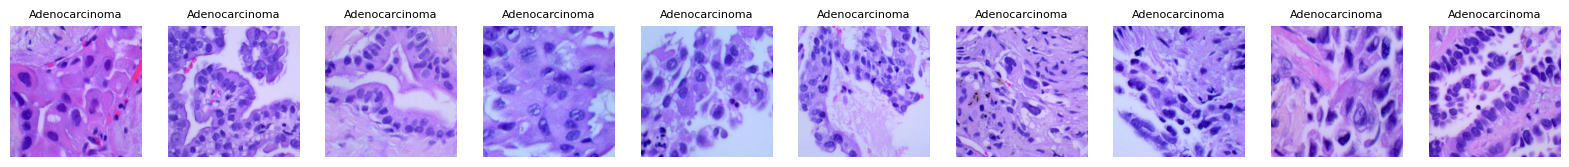

In [5]:
fig = plt.figure(figsize=(20,20))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  image = load_img(df[df["category"] == "Lung adenocarcinoma"].iloc[i]["filepath"])
  plt.imshow(image)
  plt.title("Adenocarcinoma", size=8)
  plt.axis('off')

plt.show()

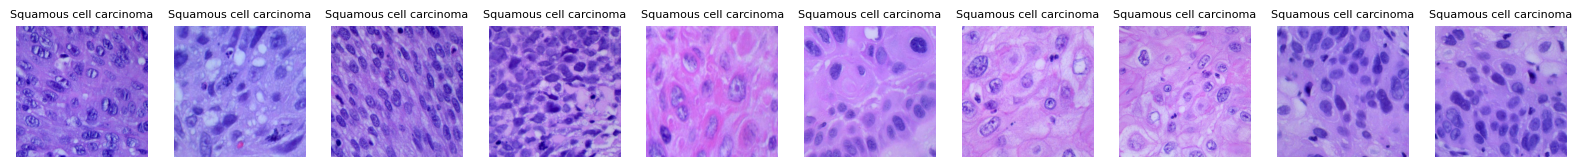

In [6]:
fig = plt.figure(figsize=(20,20))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  image = load_img(df[df["category"] == "Lung squamous cell carcinoma"].iloc[i]["filepath"])
  plt.imshow(image)
  plt.title("Squamous cell carcinoma", size=8)
  plt.axis('off')

plt.show()

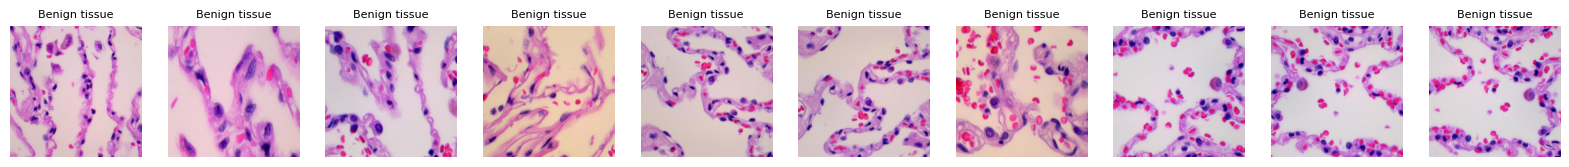

In [7]:
fig = plt.figure(figsize=(20,20))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  image = load_img(df[df["category"] == "Lung benign tissue"].iloc[i]["filepath"])
  plt.imshow(image)
  plt.title("Benign tissue", size=8)
  plt.axis('off')

plt.show()

In [8]:
strat = df["category"]
X_train, X_temp = train_test_split(df, test_size=0.2, random_state=42, stratify=strat)

strat = X_temp["category"]
X_test, X_val = train_test_split(X_temp, test_size=0.5, random_state=42, stratify=strat)

In [51]:
IMAGE_SIZE = (256, 256)
CHANNELS = 3
IMAGE_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)
CLASS_COUNT = len(df["category"].unique())
BATCH_SIZE = 64

In [69]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    X_train,
    x_col='filepath',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = test_datagen.flow_from_dataframe(
    X_val,
    x_col='filepath',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    X_test,
    x_col='filepath',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [70]:
model = Sequential()

# Mega capa 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SHAPE))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Mega capa 1
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Mega capa 1
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully conected layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(CLASS_COUNT, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

model.summary()

C:\Users\ppalm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,080,643 (225.37 MB)

 Trainable params: 59,079,171 (225.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [71]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [72]:
epochs = 30
total_train = X_test.shape[0]
total_val = X_val.shape[0]

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

Epoch 1/30


C:\Users\ppalm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.8507 - loss: 0.4815 - val_accuracy: 0.3349 - val_loss: 9.8613 - learning_rate: 0.0010
Epoch 2/30


C:\Users\ppalm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.8750 - loss: 0.4073 - val_accuracy: 0.2500 - val_loss: 11.0725 - learning_rate: 0.0010
Epoch 3/30


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


187/187 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.9285 - loss: 0.1740 - val_accuracy: 0.6957 - val_loss: 1.1909 - learning_rate: 0.0010
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - accuracy: 0.9688 - loss: 0.0988 - val_accuracy: 0.5357 - val_loss: 1.1638 - learning_rate: 0.0010
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.9602 - loss: 0.1071 - val_accuracy: 0.8906 - val_loss: 0.2657 - learning_rate: 0.0010
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step - accuracy: 0.9688 - loss: 0.1065 - val_accuracy: 0.8929 - val_loss: 0.1578 - learning_rate: 0.0010
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.9752 - loss: 0.0644 - val_accuracy: 0.7690 - val_loss: 1.0530 - learning_rate: 0.0010
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/step - accuracy: 0.9844 - loss: 0.0514 - val_accuracy: 0.8571 - val_loss: 0.5744 - learning_rate: 0.0010
Epoch 9/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.9791 - loss: 0.0569 - v

In [73]:
loss, accuracy = model.evaluate(train_generator)
print("Accuracy for training data is:", accuracy)
print("Loss for training data is:", loss)

loss, accuracy = model.evaluate(val_generator)
print("Accuracy for validation data is:", accuracy)
print("Loss for validation data is:", loss)

188/188 ━━━━━━━━━━━━━━━━━━━━ 48s 253ms/step - accuracy: 0.9594 - loss: 0.1362
Accuracy for training data is: 0.9585000276565552
Loss for training data is: 0.14143717288970947
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.9263 - loss: 0.3118
Accuracy for validation data is: 0.9319999814033508
Loss for validation data is: 0.2811058759689331


In [74]:
nb_samples = X_test.shape[0]
predict = model.predict(test_generator)
y_pred = np.argmax(predict, axis=-1)

y_true = test_generator.labels


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step


In [75]:
loss, acc = model.evaluate(test_generator)

print("Accuracy for test data is:", accuracy)
print("Loss for test data is:", loss)

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.9237 - loss: 0.3406
Accuracy for test data is: 0.9319999814033508
Loss for test data is: 0.36242589354515076


In [76]:
labels = list(train_generator.class_indices.keys())
print(labels)
print(classification_report(y_true, y_pred, target_names=labels))

['Lung adenocarcinoma', 'Lung benign tissue', 'Lung squamous cell carcinoma']
                              precision    recall  f1-score   support

         Lung adenocarcinoma       0.98      0.80      0.88       500
          Lung benign tissue       0.97      1.00      0.99       500
Lung squamous cell carcinoma       0.85      0.98      0.91       500

                    accuracy                           0.93      1500
                   macro avg       0.93      0.93      0.93      1500
                weighted avg       0.93      0.93      0.93      1500



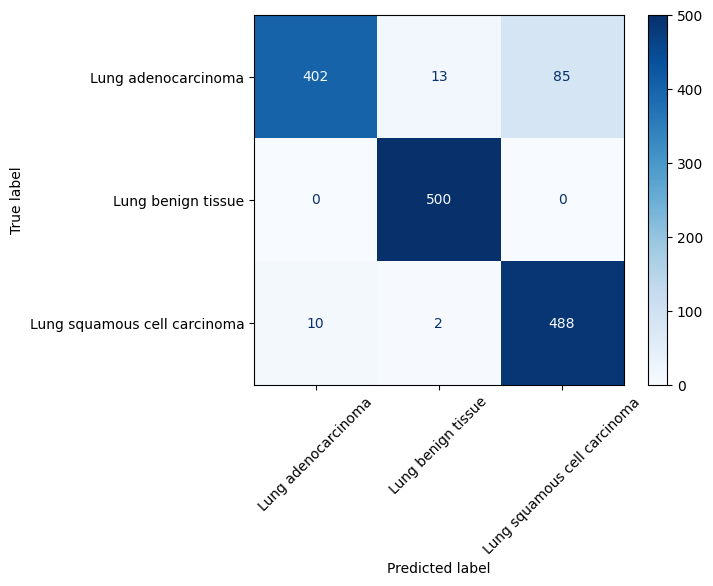

In [77]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()

In [79]:
model.save("model.keras")